In [1]:
# import torch and numpy and pretrained model
from torchvision import models
import torch
import numpy as np
import os

# load pretrained model
pretrained_model = models.resnet50(weights = 'DEFAULT', progress = True)

In [2]:
# changes fully connected/classifier layer to new layer for us to train, 15 is the number of solutions or types of leaves
pretrained_model.fc = torch.nn.Linear(2048, 15)

In [3]:
# # Currently not in use, for if we wanna custom build a softmax but idk how to train it
# import torch.nn as nn
# # build custom softmax module
# class Softmax(nn.Module):
#     def __init__(self, n_inputs, n_outputs):
#         super().__init__()
#         self.linear = nn.Linear(n_inputs, n_outputs)
 
#     def forward(self, x):
#         pred = self.linear(x)
#         return pred

In [4]:
# # Currently not in use
# # adds softmax to model
# class MyModel(nn.Module):
#     def __init__(self, pretrained_model):
#         super(MyModel, self).__init__()
#         self.pretrained_model = pretrained_model
#         self.last_layer = Softmax(1000, n) # add how many nodes as input and output

#     def forward(self, x):
#         return self.last_layer(self.pretrained_model(x))

# model = MyModel(pretrained_model)

In [5]:
#freeze model except fc layer because we don't wanna retrain the pretrained model
for param in pretrained_model.parameters():
    param.requires_grad = False

for param in pretrained_model.fc.parameters():
    param.requires_grad = True

In [6]:
criterion = torch.nn.CrossEntropyLoss() #could write this out ourselves
# need to find an optimizer or make one for a custom softmax function
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001) #need optimize learning rate idk how momentum works

In [13]:
#import data
from PIL import Image
import os
from sklearn.preprocessing import OneHotEncoder
data_dir = "/Users/stevenli/SigAida/data/images/" #change to data directory

# gets the label based on the number
def getLabel(s):
    labels = {1 : 'Ulmus carpinifolia', 
                2 : 'Acer', 
                3 : 'Salix aurita', 
                4 : 'Quercus', 
                5 : 'Alnus incan', 
                6 : 'Betula pubescens', 
                7 : 'Salix alba \'Sericea\'', 
                8 : 'Populus tremula', 
                9 : 'Ulmus glabra', 
                10 : 'Sorbus aucuparia', 
                11 : 'Salix sinerea', 
                12 : 'Populus', 
                13 : 'Tilia', 
                14 : 'Sorbus intermedia', 
                15 : 'Fagus silvatica'}
    return labels.get(int(s))

im = [] # images
la = [] # labels not in use, because you can't feed strings to gpu, need to feed tensors
ohe = [] #s toring int values for one hot encodings
joined = []

for f in os.listdir(data_dir):
    im.append(data_dir + f)
    val = int(f[:-9].replace('l','')) # removes last 9 letters replaces l with blank then gets label
    la.append(getLabel(val)) 
    ohe.append(val)

#one hot encoding (changing 1-15 to tensors for gpu)
encoded = OneHotEncoder(categories = [[x for x in range(1, 16)]], sparse = False).fit_transform(np.array(ohe).reshape((len(ohe),1)))
# print(encoded)

#joining image and label for organization and if we wanna shuffle
for image, label in zip(im, encoded):
    joined.append([image, label])

# print(la)
# print(im)
# print(joined[1])

l8nr039.tif
l9nr039.tif
l9nr011.tif
l8nr005.tif
l8nr011.tif
l9nr005.tif
l10nr050.tif
l11nr044.tif
l11nr050.tif
l10nr044.tif
l3nr006.tif
l2nr012.tif
l2nr006.tif
l3nr012.tif
l1nr055.tif
l1nr041.tif
l12nr003.tif
l1nr069.tif
l13nr017.tif
l13nr003.tif
l12nr017.tif
l5nr063.tif
l4nr063.tif
l6nr018.tif
l15nr072.tif
l14nr066.tif
l7nr018.tif
l14nr072.tif
l15nr066.tif
l6nr024.tif
l7nr030.tif
l7nr024.tif
l6nr030.tif
l7nr025.tif
l6nr031.tif
l6nr025.tif
l7nr031.tif
l14nr073.tif
l7nr019.tif
l15nr067.tif
l15nr073.tif
l6nr019.tif
l14nr067.tif
l4nr062.tif
l5nr062.tif
l13nr002.tif
l12nr016.tif
l1nr068.tif
l12nr002.tif
l13nr016.tif
l1nr040.tif
l1nr054.tif
l2nr007.tif
l3nr013.tif
l3nr007.tif
l2nr013.tif
l11nr051.tif
l10nr045.tif
l10nr051.tif
l11nr045.tif
l8nr010.tif
l9nr004.tif
l9nr010.tif
l8nr004.tif
l9nr038.tif
l8nr038.tif
l9nr006.tif
l8nr012.tif
l8nr006.tif
l9nr012.tif
l10nr047.tif
l11nr053.tif
l2nr039.tif
l11nr047.tif
l10nr053.tif
l3nr039.tif
l3nr011.tif
l2nr005.tif
l2nr011.tif
l3nr005.tif
l12nr028.tif

/Users/stevenli/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
# some preprocessing, randomize data, split data, load into dataloaders
import random

# splits (train, val, test) test currently not in use
split_ratio=(0.8, 0.1, 0.1)

def create_splits(data, split_ratio):
    random.shuffle(data)
    train = [data[i] for i in range(0, round(.8 * len(data)))]
    val = [data[i] for i in range(round(.8 * len(data)), round(.9 * len(data)))]
    test = [data[i] for i in range(round(.9 * len(data)), len(data))]
    return train, val, test

train, val, test = create_splits(joined, split_ratio)

print(len(joined))
print(len(train))
print(len(val))
print(len(test))

1125
900
112
113


In [21]:
#making dataset
from torch.utils.data import Dataset

#prevents some truncated bs
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# makes a custom dataset based on pytorch dataset class
class PlantDataset(Dataset):
    def __init__(self, data_dir, arr, transform = None, augment = None):
        # initialize some valuess
        self.data_dir = data_dir
        self.data = [x[0] for x in arr]
        self.augments = augment

        self.arr = self.augment(arr, self.augments, data_dir)

        #transform to normalize/resize all images
        self.transform = transform

    # data augmentation helper function
    def augment(self, arr, transforms, data_dir):
        ims = [Image.open(i[0]) for i in arr]
        # print(len(ims))
        lbs = [i[1] for i in arr]

        #transform and write out into data_dir then concatenate to arr with original label
        n = 3 #how many x do you want to make the data
        counter = 1
        for im, lb in zip(ims, lbs):
            for j in range(n):
                temp = transforms(im)
                filename = data_dir + str(counter) + "image" + str(j) + "version" + str(np.where(lb == 1)[0][0] + 1) + "label.tif"
                temp.save(filename)
                temp.close()

                arr.append((filename, lb))
            counter += 1
        return arr
    
    def __len__(self):
        return len(self.arr)
    
    def __getitem__(self, idx):
        img = self.transform(Image.open(self.arr[idx][0]))
        s = self.arr[idx][1]
        #returns a tuple of the transformed image and the label (one-hot encoding)
        return (img, s)

In [22]:
import torchvision.transforms as transforms

#defining our transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)), # change to what data should be
    transforms.ToTensor(),
    ])

#list of augments, rotation, affine (translation)
augments = transforms.Compose([transforms.Resize((224, 224)),
                              transforms.RandomRotation(8,fill=0),
                              transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=0)]) 

#making dataset and dataloader
train_dataset = PlantDataset(data_dir, train, transform = transform, augment=augments) #probably need to make this bigger
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [23]:
print(len(train_dataset))

3600


In [ ]:
#chcek devices change to whatever you're using

#mps = (m1/m2 mac) gpu

print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

#set device
device = torch.device('mps')

from tqdm import tqdm # progress

True
True


In [ ]:
#testing accuracy on test dataset
total_correct = 0
total_instances = 0

pretrained_model.eval()
# iterating through batches without updating gradients
with torch.no_grad():
    for images, labels in tqdm(train_loader):
      pretrained_model.to(device)
      images = images.to(device)
      # labels = labels.float().to(device) # don't need this cuz we not training no more

      # making classifications and deriving indices of maximum value via argmax (which gives the max value i the tensor)
      solution_tensor = pretrained_model(images)
      classifications = torch.argmax(solution_tensor, dim = 1).item()

      #undoing one-hot encoding to get label value as a number
      label = np.where(labels.numpy() == 1)[1]

      correct_predictions = int(classifications==label)

      #  incrementing counters
      total_correct+=correct_predictions
      total_instances+=len(images)

#print accuracy
print("basline before training")
print(round(total_correct/total_instances, 3))

100%|██████████| 900/900 [00:59<00:00, 15.24it/s]


basline before training
0.072


In [ ]:
# Train the model
pretrained_model.train()
num_epochs = 200

#store loss
loss_history = []

#change batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(num_epochs):
    for data, label in tqdm(train_loader):
        # Move tensors to the configured device
        pretrained_model.to(device)
        images = data.to(device)
        labels = label.float().to(device) #.float() for some float64, float32 conversion thing, don't completely understand

        optimizer.zero_grad()
        
        # Forward pass
        outputs = pretrained_model(images) #currently image tensor don't match fc layer if you use non pretrained model
        loss = criterion(outputs, labels) #calculate loss

        # Backward and optimize don't really understand this stuff
        loss.backward()
        optimizer.step()

        # Print some statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

100%|██████████| 29/29 [00:44<00:00,  1.55s/it]


Epoch [1/200], Loss: 1.7673


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch [2/200], Loss: 1.2761


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch [3/200], Loss: 1.1740


100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


Epoch [4/200], Loss: 0.4241


100%|██████████| 29/29 [00:31<00:00,  1.07s/it]


Epoch [5/200], Loss: 0.5423


100%|██████████| 29/29 [00:29<00:00,  1.00s/it]


Epoch [6/200], Loss: 0.2975


100%|██████████| 29/29 [00:31<00:00,  1.10s/it]


Epoch [7/200], Loss: 0.3875


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch [8/200], Loss: 0.3578


100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


Epoch [9/200], Loss: 0.5751


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch [10/200], Loss: 0.2177


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch [11/200], Loss: 0.3588


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch [12/200], Loss: 0.9886


100%|██████████| 29/29 [00:31<00:00,  1.09s/it]


Epoch [13/200], Loss: 0.5829


100%|██████████| 29/29 [00:30<00:00,  1.05s/it]


Epoch [14/200], Loss: 1.1070


100%|██████████| 29/29 [00:36<00:00,  1.26s/it]


Epoch [15/200], Loss: 0.5514


100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


Epoch [16/200], Loss: 0.1287


100%|██████████| 29/29 [00:29<00:00,  1.00s/it]


Epoch [17/200], Loss: 0.1698


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch [18/200], Loss: 0.2479


100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Epoch [19/200], Loss: 0.1061


100%|██████████| 29/29 [00:30<00:00,  1.05s/it]


Epoch [20/200], Loss: 0.1362


100%|██████████| 29/29 [00:28<00:00,  1.00it/s]


Epoch [21/200], Loss: 0.3723


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch [22/200], Loss: 0.1713


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch [23/200], Loss: 0.1681


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [24/200], Loss: 0.2566


100%|██████████| 29/29 [00:31<00:00,  1.09s/it]


Epoch [25/200], Loss: 0.2296


100%|██████████| 29/29 [00:29<00:00,  1.00s/it]


Epoch [26/200], Loss: 0.0668


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch [27/200], Loss: 0.1301


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch [28/200], Loss: 0.5456


100%|██████████| 29/29 [00:27<00:00,  1.07it/s]


Epoch [29/200], Loss: 0.0867


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Epoch [30/200], Loss: 0.0528


100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Epoch [31/200], Loss: 0.0782


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


Epoch [32/200], Loss: 0.5070


100%|██████████| 29/29 [00:26<00:00,  1.07it/s]


Epoch [33/200], Loss: 0.0779


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [34/200], Loss: 2.8828


100%|██████████| 29/29 [00:27<00:00,  1.07it/s]


Epoch [35/200], Loss: 0.1259


100%|██████████| 29/29 [00:30<00:00,  1.05s/it]


Epoch [36/200], Loss: 0.1705


100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


Epoch [37/200], Loss: 0.0286


100%|██████████| 29/29 [00:31<00:00,  1.07s/it]


Epoch [38/200], Loss: 0.1950


100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Epoch [39/200], Loss: 0.0420


100%|██████████| 29/29 [00:29<00:00,  1.03s/it]


Epoch [40/200], Loss: 0.3154


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch [41/200], Loss: 0.3673


100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


Epoch [42/200], Loss: 0.0522


100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Epoch [43/200], Loss: 0.0314


100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Epoch [44/200], Loss: 0.3456


100%|██████████| 29/29 [00:33<00:00,  1.15s/it]


Epoch [45/200], Loss: 0.0472


100%|██████████| 29/29 [00:32<00:00,  1.12s/it]


Epoch [46/200], Loss: 0.0409


100%|██████████| 29/29 [00:31<00:00,  1.10s/it]


Epoch [47/200], Loss: 0.1604


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch [48/200], Loss: 0.0914


100%|██████████| 29/29 [00:35<00:00,  1.23s/it]


Epoch [49/200], Loss: 0.0236


100%|██████████| 29/29 [00:31<00:00,  1.09s/it]


Epoch [50/200], Loss: 0.3328


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Epoch [51/200], Loss: 0.0929


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch [52/200], Loss: 0.2297


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Epoch [53/200], Loss: 0.5582


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [54/200], Loss: 0.0098


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [55/200], Loss: 0.0730


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Epoch [56/200], Loss: 0.0335


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [57/200], Loss: 0.0609


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Epoch [58/200], Loss: 0.0564


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Epoch [59/200], Loss: 0.0350


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Epoch [60/200], Loss: 0.0804


100%|██████████| 29/29 [00:26<00:00,  1.12it/s]


Epoch [61/200], Loss: 0.0481


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Epoch [62/200], Loss: 0.1577


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Epoch [63/200], Loss: 0.1890


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [64/200], Loss: 0.1377


100%|██████████| 29/29 [00:32<00:00,  1.12s/it]


Epoch [65/200], Loss: 0.0315


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [66/200], Loss: 0.0239


100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Epoch [67/200], Loss: 0.0178


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Epoch [68/200], Loss: 0.0742


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch [69/200], Loss: 0.0235


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Epoch [70/200], Loss: 0.0084


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch [71/200], Loss: 0.0516


100%|██████████| 29/29 [00:27<00:00,  1.07it/s]


Epoch [72/200], Loss: 0.0378


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [73/200], Loss: 0.2408


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Epoch [74/200], Loss: 0.0314


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [75/200], Loss: 0.0660


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch [76/200], Loss: 0.0331


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [77/200], Loss: 0.0114


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [78/200], Loss: 0.1296


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch [79/200], Loss: 0.1471


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Epoch [80/200], Loss: 0.1773


100%|██████████| 29/29 [00:30<00:00,  1.05s/it]


Epoch [81/200], Loss: 0.0504


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


Epoch [82/200], Loss: 0.0339


100%|██████████| 29/29 [00:32<00:00,  1.12s/it]


Epoch [83/200], Loss: 0.0173


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch [84/200], Loss: 0.0216


100%|██████████| 29/29 [00:31<00:00,  1.10s/it]


Epoch [85/200], Loss: 0.5571


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Epoch [86/200], Loss: 0.3456


100%|██████████| 29/29 [00:30<00:00,  1.05s/it]


Epoch [87/200], Loss: 0.0284


100%|██████████| 29/29 [00:31<00:00,  1.08s/it]


Epoch [88/200], Loss: 0.0547


100%|██████████| 29/29 [00:31<00:00,  1.10s/it]


Epoch [89/200], Loss: 0.0214


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch [90/200], Loss: 0.0630


100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


Epoch [91/200], Loss: 0.0212


100%|██████████| 29/29 [00:31<00:00,  1.09s/it]


Epoch [92/200], Loss: 0.0274


100%|██████████| 29/29 [00:29<00:00,  1.03s/it]


Epoch [93/200], Loss: 0.0283


100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


Epoch [94/200], Loss: 0.0067


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [95/200], Loss: 0.0226


100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


Epoch [96/200], Loss: 0.0021


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch [97/200], Loss: 0.0467


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


Epoch [98/200], Loss: 0.0176


100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


Epoch [99/200], Loss: 0.3410


100%|██████████| 29/29 [00:32<00:00,  1.14s/it]


Epoch [100/200], Loss: 0.0334


100%|██████████| 29/29 [00:33<00:00,  1.15s/it]


Epoch [101/200], Loss: 0.0430


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


Epoch [102/200], Loss: 0.0994


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [103/200], Loss: 0.0390


100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


Epoch [104/200], Loss: 0.0719


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [105/200], Loss: 0.1492


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Epoch [106/200], Loss: 0.0204


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [107/200], Loss: 1.4283


100%|██████████| 29/29 [00:28<00:00,  1.00it/s]


Epoch [108/200], Loss: 0.2381


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Epoch [109/200], Loss: 0.0594


100%|██████████| 29/29 [00:33<00:00,  1.15s/it]


Epoch [110/200], Loss: 0.0073


100%|██████████| 29/29 [00:37<00:00,  1.31s/it]


Epoch [111/200], Loss: 0.0217


100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


Epoch [112/200], Loss: 0.0258


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [113/200], Loss: 0.0054


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch [114/200], Loss: 0.0168


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [115/200], Loss: 0.0126


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch [116/200], Loss: 0.0761


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [117/200], Loss: 0.3055


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [118/200], Loss: 0.1967


100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


Epoch [119/200], Loss: 0.0210


100%|██████████| 29/29 [00:34<00:00,  1.20s/it]


Epoch [120/200], Loss: 0.0090


100%|██████████| 29/29 [00:31<00:00,  1.07s/it]


Epoch [121/200], Loss: 0.0262


100%|██████████| 29/29 [00:31<00:00,  1.10s/it]


Epoch [122/200], Loss: 0.0037


100%|██████████| 29/29 [00:29<00:00,  1.03s/it]


Epoch [123/200], Loss: 0.1077


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [124/200], Loss: 0.0173


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Epoch [125/200], Loss: 0.0610


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Epoch [126/200], Loss: 0.0285


100%|██████████| 29/29 [00:25<00:00,  1.14it/s]


Epoch [127/200], Loss: 0.0281


100%|██████████| 29/29 [00:25<00:00,  1.16it/s]


Epoch [128/200], Loss: 0.0838


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Epoch [129/200], Loss: 0.0462


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [130/200], Loss: 0.0079


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch [131/200], Loss: 0.1091


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [132/200], Loss: 0.1659


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [133/200], Loss: 0.1511


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch [134/200], Loss: 0.0789


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch [135/200], Loss: 0.0378


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Epoch [136/200], Loss: 0.0191


100%|██████████| 29/29 [00:26<00:00,  1.07it/s]


Epoch [137/200], Loss: 0.1079


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Epoch [138/200], Loss: 0.0699


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch [139/200], Loss: 0.1088


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Epoch [140/200], Loss: 0.0342


100%|██████████| 29/29 [00:25<00:00,  1.14it/s]


Epoch [141/200], Loss: 0.7119


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [142/200], Loss: 0.0594


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [143/200], Loss: 0.0133


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Epoch [144/200], Loss: 0.0318


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


Epoch [145/200], Loss: 0.0024


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch [146/200], Loss: 0.0513


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch [147/200], Loss: 0.0087


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch [148/200], Loss: 0.0097


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [149/200], Loss: 0.0059


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Epoch [150/200], Loss: 0.0590


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [151/200], Loss: 0.0251


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [152/200], Loss: 0.0893


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Epoch [153/200], Loss: 0.0249


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Epoch [154/200], Loss: 0.0109


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch [155/200], Loss: 0.0090


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Epoch [156/200], Loss: 0.0131


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Epoch [157/200], Loss: 0.0720


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [158/200], Loss: 0.0335


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch [159/200], Loss: 0.1032


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Epoch [160/200], Loss: 0.0198


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch [161/200], Loss: 0.9571


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [162/200], Loss: 0.0392


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [163/200], Loss: 0.0958


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Epoch [164/200], Loss: 0.0108


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [165/200], Loss: 0.0133


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [166/200], Loss: 0.0374


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [167/200], Loss: 0.0129


100%|██████████| 29/29 [00:25<00:00,  1.14it/s]


Epoch [168/200], Loss: 0.0133


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Epoch [169/200], Loss: 0.0259


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Epoch [170/200], Loss: 0.0095


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Epoch [171/200], Loss: 0.0457


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [172/200], Loss: 0.0412


100%|██████████| 29/29 [00:25<00:00,  1.14it/s]


Epoch [173/200], Loss: 0.0111


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch [174/200], Loss: 0.0184


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [175/200], Loss: 0.2556


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch [176/200], Loss: 0.0025


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Epoch [177/200], Loss: 0.1006


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [178/200], Loss: 0.0064


100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


Epoch [179/200], Loss: 0.7811


100%|██████████| 29/29 [00:27<00:00,  1.07it/s]


Epoch [180/200], Loss: 0.0152


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch [181/200], Loss: 0.0031


100%|██████████| 29/29 [00:24<00:00,  1.18it/s]


Epoch [182/200], Loss: 0.0349


100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


Epoch [183/200], Loss: 0.0223


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Epoch [184/200], Loss: 0.0023


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Epoch [185/200], Loss: 0.0047


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Epoch [186/200], Loss: 0.0153


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Epoch [187/200], Loss: 0.0089


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Epoch [188/200], Loss: 0.0015


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [189/200], Loss: 0.0012


100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


Epoch [190/200], Loss: 0.2646


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch [191/200], Loss: 0.9100


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Epoch [192/200], Loss: 0.2477


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Epoch [193/200], Loss: 0.0196


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Epoch [194/200], Loss: 0.0096


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Epoch [195/200], Loss: 0.1932


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch [196/200], Loss: 0.0017


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Epoch [197/200], Loss: 0.0107


100%|██████████| 29/29 [00:24<00:00,  1.17it/s]


Epoch [198/200], Loss: 0.0070


100%|██████████| 29/29 [00:27<00:00,  1.07it/s]


Epoch [199/200], Loss: 0.1513


100%|██████████| 29/29 [00:26<00:00,  1.12it/s]

Epoch [200/200], Loss: 1.0291


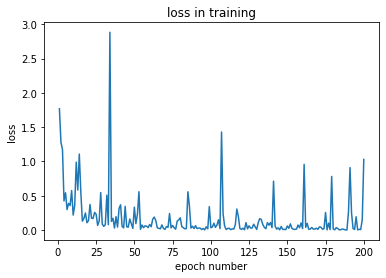

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(1, num_epochs + 1)]
    
# plotting the points   
plt.plot(x, loss_history)  
    
# naming the x axis  
plt.xlabel('epoch number')  
# naming the y axis  
plt.ylabel('loss')  
    
# giving a title to my graph  
plt.title('loss in training')  
    
# function to show the plot  
plt.show()  

In [ ]:
#testing accuracy on test dataset
total_correct = 0
total_instances = 0

#chang back batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

pretrained_model.eval()
# iterating through batches without updating gradients
with torch.no_grad():
    for images, labels in tqdm(train_loader):
      images = images.to(device)
      # labels = labels.float().to(device) # don't need this cuz we not training no more

      # making classifications and deriving indices of maximum value via argmax (which gives the max value i the tensor)
      solution_tensor = pretrained_model(images)
      classifications = torch.argmax(solution_tensor, dim = 1).item()

      #undoing one-hot encoding to get label value as a number
      label = np.where(labels.numpy() == 1)[1]

      correct_predictions = int(classifications==label)

      #  incrementing counters
      total_correct+=correct_predictions
      total_instances+=len(images)

#print accuracy
print("after training")
print(round(total_correct/total_instances, 3))

100%|██████████| 900/900 [00:49<00:00, 18.07it/s]

after training
1.0


In [ ]:
#loading validation dataset
val_dataset = PlantDataset(data_dir, val, transform = transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

In [ ]:
total_correct = 0
total_instances = 0

pretrained_model.eval()
# iterating through batches without updating gradients
with torch.no_grad():
    for images, labels in tqdm(val_loader):
      images = images.to(device)
      # labels = labels.float().to(device) # don't need this cuz we not training no more

      # making classifications and deriving indices of maximum value via argmax (which gives the max value i the tensor)
      solution_tensor = pretrained_model(images)
      classifications = torch.argmax(solution_tensor, dim = 1).item()

      #undoing one-hot encoding to get label value as a number
      label = np.where(labels.numpy() == 1)[1]

      correct_predictions = int(classifications==label)

      #  incrementing counters
      total_correct+=correct_predictions
      total_instances+=len(images)

#print accuracy
print(round(total_correct/total_instances, 3))

100%|██████████| 112/112 [00:06<00:00, 18.31it/s]

1.0


In [ ]:
#loading test dataset
test_dataset = PlantDataset(data_dir, test, transform = transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
total_correct = 0
total_instances = 0

pictures = []
model_guesses = []
correct_answers = []

# iterating through batches without updating gradients
with torch.no_grad():
    for images, labels in tqdm(test_loader):
      pictures.append(images)
      images = images.to(device)

      # making classifications and deriving indices of maximum value via argmax (which gives the max value i the tensor)
      solution_tensor = pretrained_model(images)
      classifications = torch.argmax(solution_tensor, dim = 1).item()
      model_guesses.append(getLabel(classifications + 1)) # + 1 to convert from index to dict key

      #undoing one-hot encoding to get label value as a number
      label = np.where(labels.numpy() == 1)[1]
      correct_answers.append(getLabel(label + 1)) # + 1 to convert from index to dict key

      correct_predictions = int(classifications==label)

      #  incrementing counters
      total_correct+=correct_predictions
      total_instances+=len(images)

#print accuracy
print(round(total_correct/total_instances, 3))

100%|██████████| 113/113 [00:05<00:00, 19.12it/s]

1.0


In [ ]:
#dump to pickle
import pickle
pickle.dump(pretrained_model, open('model.pkl', 'wb'))